In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()

np.random.seed(12345)

## Import data

In [2]:
draws = pd.read_csv('./data/processed/draws.csv', index_col=0)
shares = pd.read_csv('./data/processed/shares.csv')
outlets = pd.read_csv('./data/processed/outlets.csv')

In [3]:
draws['format'] = draws.index.map(lambda draw_no: '456' if draw_no < 2995 else '496')
numbers = draws.loc[:, 'win_1':'additional']
draws.drop(columns=['win_1', 'win_2', 'win_3', 'win_4', 'win_5', 'win_6', 'additional'], inplace=True)

In [4]:
draws.head()

,draw_date,week,day_of_week,is_hong_bao,total_allocated,prize_pool,snowballed_1,snowballed_2,consecutive,discrepency,format
draw_no,,,,,,,,,,,
1335,"Thu, 12 Nov 1998",1998W46,4,0,1404459,1439536,0,0,0,75616,456
1336,"Mon, 16 Nov 1998",1998W47,1,0,2180546,2184513,500000,0,1,-76646,456
1337,"Thu, 19 Nov 1998",1998W47,4,0,3668417,3834538,1195596,0,2,-1345,456
1338,"Mon, 23 Nov 1998",1998W48,1,0,8992368,9521025,2460753,0,3,-3229,456
1339,"Thu, 26 Nov 1998",1998W48,4,0,1441537,1534315,0,0,0,-912,456


In [5]:
numbers.head()

,win_1,win_2,win_3,win_4,win_5,win_6,additional
draw_no,,,,,,,
1335,1,2,22,25,28,39,4
1336,9,18,22,32,34,39,15
1337,1,2,7,28,35,37,40
1338,7,23,34,36,42,43,37
1339,10,21,24,25,36,42,41


In [6]:
shares.head()

,draw,group,shareAmount,numberOfShares,snowballed,cascaded,allocated
0,1335,Group 1,500000,0,NaN,NaN,500000
1,1335,Group 2,187090,1,NaN,NaN,187090
2,1335,Group 3,1853,101,NaN,NaN,187153
3,1335,Group 4,709,264,NaN,NaN,187176
4,1335,Group 5,30,5964,NaN,NaN,178920


In [7]:
outlets.head()

,draw,group,outlet,quickpick,bet_type
0,1338,Group 1,Nan Huat Wine Store - Blk 513 Bishan St 13 #01...,1,System 7 Entry
1,1339,Group 1,Seng Yeok Chan Agency - Blk 338 Ang Mo Kio Ave...,0,System Roll Entry
2,1340,Group 1,Milly Trading Store - Blk 374 Bukit Batok St 3...,1,Ordinary Entry
3,1340,Group 1,Papillon Florist Pte Ltd - Blk 133 Jalan Bukit...,0,Ordinary Entry
4,1342,Group 1,Vijaya Darshana Agency - 810 Geylang Rd City P...,1,System 8 Entry


In [8]:
jackpots = shares[shares['group'] == 'Group 1'].set_index('draw')
jackpots = jackpots['shareAmount'] * jackpots['numberOfShares'].apply(lambda n: n or 1)

## Most chosen numbers

In [9]:
shares_pvt = pd.pivot_table(shares, values='numberOfShares', index='draw', columns='group')
shares_pvt['additional'] = numbers['additional']

In [10]:
num_attrs = pd.DataFrame({'num': range(1, 50)})
num_attrs['first_digit'] = num_attrs['num'] // 10
num_attrs['last_digit'] = num_attrs['num'] % 10
num_attrs['row'] = (num_attrs['num'] - 1) // 9
num_attrs['col'] = (num_attrs['num'] - 1) % 9
num_attrs.set_index('num', inplace=True)

In [11]:
shares_pvt['incl_additional'] = shares_pvt['Group 2'] + shares_pvt['Group 4'] + shares_pvt['Group 6']
draws['tickets'] = draws['prize_pool'] / 0.5 / ((draws['format'] == '496').astype(float) * 0.5 + 0.5)
shares_pvt['tickets_sold'] = draws['tickets']

In [12]:
shares_pvt.head()

group,Group 1,Group 2,Group 3,Group 4,Group 5,Group 6,Group 7,additional,incl_additional,tickets_sold
draw,,,,,,,,,,
1335,0.0,1.0,101.0,264.0,5964.0,8206.0,NaN,4,8471.0,5758144.0
1336,0.0,4.0,212.0,616.0,10085.0,16522.0,NaN,15,17142.0,8738052.0
1337,0.0,10.0,320.0,875.0,17131.0,19681.0,NaN,40,20566.0,15338152.0
1338,1.0,29.0,796.0,2192.0,38351.0,49335.0,NaN,37,51556.0,38084100.0
1339,1.0,4.0,160.0,291.0,5971.0,7885.0,NaN,41,8180.0,6137260.0


In [13]:
def get_popularity(df):
    output = pd.pivot_table(df, values=['incl_additional', 'tickets_sold'], index='additional')
    output['norm_votes'] = output['incl_additional'] / output['tickets_sold']
    output['norm_votes'] = output['norm_votes'] / output['norm_votes'].min()
    return output.join(num_attrs)

In [14]:
def layout_numbers(data, rows, cols, pad):
    arr = np.array(data)
    return np.pad(arr, (0, rows * cols - len(arr)), 'constant', constant_values=(pad, pad)).reshape(rows, cols)

In [15]:
popularity_456 = get_popularity(shares_pvt[draws['format'] == '456'])
popularity_456_sorted = popularity_456.sort_values('norm_votes', ascending=False)

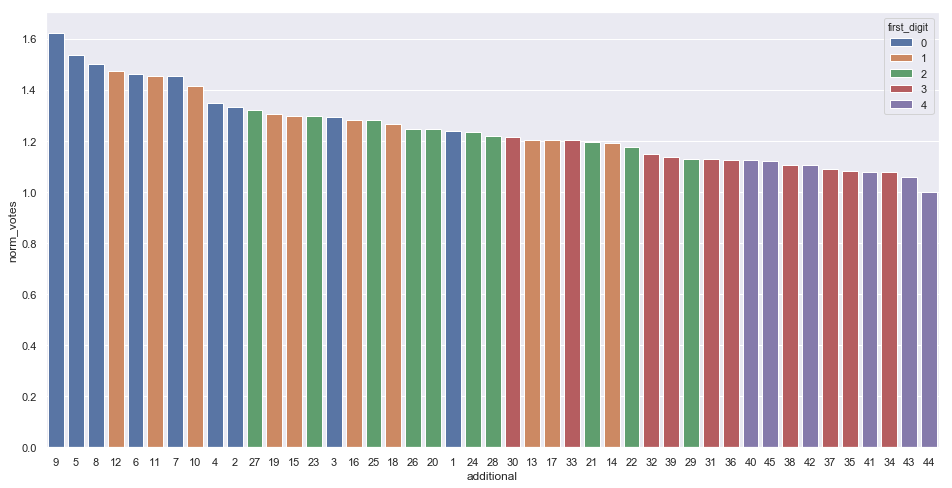

In [16]:
plt.figure(figsize=(16,8))
sns.barplot(data=popularity_456, x=popularity_456.index, y='norm_votes', hue='first_digit', order=popularity_456_sorted.index, dodge=False)

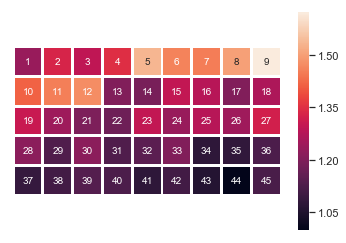

In [17]:
sns.heatmap(data=layout_numbers(popularity_456['norm_votes'], 5, 9, 1), annot=layout_numbers(popularity_456.index, 5, 9, 0),
            square=True, linewidths=2, xticklabels=False, yticklabels=False)

In [18]:
popularity_496 = get_popularity(shares_pvt[draws['format'] == '496'])
popularity_496_sorted = popularity_496.sort_values('norm_votes', ascending=False)

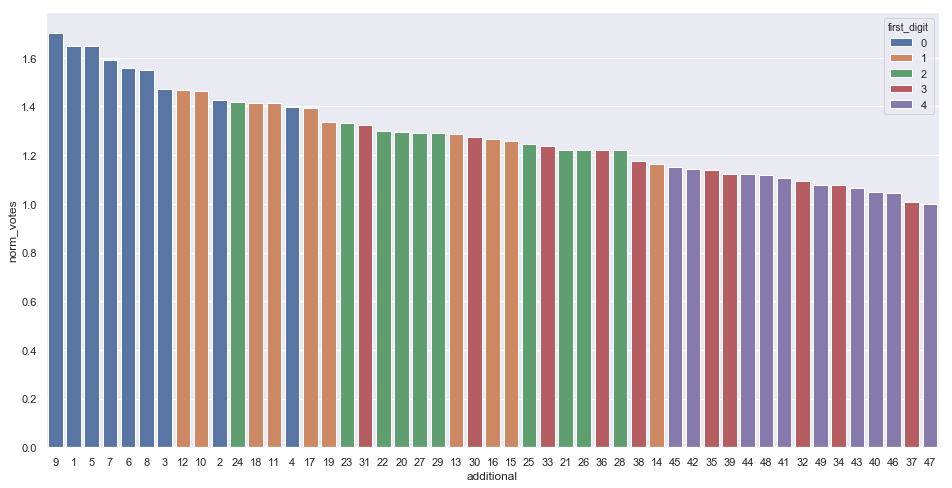

In [19]:
plt.figure(figsize=(16,8))
sns.barplot(data=popularity_496, x=popularity_496.index, y='norm_votes', hue='first_digit', order=popularity_496_sorted.index, dodge=False)

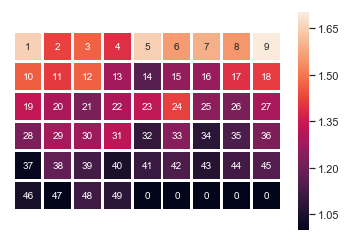

In [20]:
sns.heatmap(data=layout_numbers(popularity_496['norm_votes'], 6, 9, 1), annot=layout_numbers(popularity_496.index, 6, 9, 0),
            square=True, linewidths=2, xticklabels=False, yticklabels=False)

## Predicting demand

In [21]:
def process_unusual(df):
    df['top_up'] = df.index.map(lambda draw: 0.38 if draw >= 2995 else 0.33) * df['discrepency']
    df['jackpot'] = jackpots
    return df

In [22]:
draws['usual'] = draws['discrepency'] < 100000
hong_baos = process_unusual(draws[draws['is_hong_bao'] == 1])
fridays = process_unusual(draws[~draws['usual'] & ~draws['is_hong_bao']])

/Users/yongjun/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/yongjun/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [23]:
hong_baos

,draw_date,week,day_of_week,is_hong_bao,total_allocated,prize_pool,snowballed_1,snowballed_2,consecutive,discrepency,format,tickets,usual,top_up,jackpot
draw_no,,,,,,,,,,,,,,,
1465,"Thu, 10 Feb 2000",2000W06,4,1,22815240,18194385,0,0,0,15143797,456,72777540.0,False,4997453.01,11001600
1567,"Thu, 01 Feb 2001",2001W05,4,1,19150750,14299854,0,0,0,16008864,456,57199416.0,False,5282925.12,10001877
1678,"Mon, 25 Feb 2002",2002W09,1,1,24320516,19689754,1299345,0,1,15147101,456,78759016.0,False,4998543.33,12795507
1779,"Thu, 13 Feb 2003",2003W07,4,1,23346602,18445385,0,0,0,15139500,456,73781540.0,False,4996035.00,11083012
1881,"Thu, 05 Feb 2004",2004W06,4,1,22976196,19839556,0,0,0,10597410,456,79358224.0,False,3497145.30,10044199
1989,"Thu, 17 Feb 2005",2005W07,4,1,22782839,19272972,0,0,0,11198665,456,77091888.0,False,3695559.45,10055640
2091,"Fri, 10 Feb 2006",2006W06,5,1,25885943,22389526,0,0,0,9084074,456,89558104.0,False,2997744.42,10386288
2201,"Fri, 02 Mar 2007",2007W09,5,1,25724540,22782010,0,0,0,9077493,456,91128040.0,False,2995572.69,10513636
2303,"Thu, 21 Feb 2008",2008W08,4,1,25069638,21868303,0,0,0,9080728,456,87473212.0,False,2996640.24,10213180


In [24]:
fridays

,draw_date,week,day_of_week,is_hong_bao,total_allocated,prize_pool,snowballed_1,snowballed_2,consecutive,discrepency,format,tickets,usual,top_up,jackpot
draw_no,,,,,,,,,,,,,,,
1453,"Thu, 30 Dec 1999",1999W52,4,0,21420953,16714336,0,0,0,15140519,456,66857344.0,False,4996371.27,10512102
2159,"Fri, 06 Oct 2006",2006W40,5,0,11935025,10204782,732852,0,1,5750491,456,40819128.0,False,1897662.03,5998092
2237,"Fri, 06 Jul 2007",2007W27,5,0,13958952,10249146,790325,0,1,5746596,456,40996584.0,False,1896376.68,6068920
2259,"Fri, 21 Sep 2007",2007W38,5,0,10745826,8249633,0,0,0,7722758,456,32998532.0,False,2548510.14,5270889
2329,"Fri, 23 May 2008",2008W21,5,0,12156568,8575579,0,0,0,6657730,456,34302316.0,False,2197050.90,5026992
2351,"Fri, 08 Aug 2008",2008W32,5,0,18032668,15569959,0,0,0,8747932,456,62279836.0,False,2886817.56,8024904
2433,"Fri, 22 May 2009",2009W21,5,0,11811810,9962910,0,0,0,5451741,456,39851640.0,False,1799074.53,5086835
2469,"Fri, 25 Sep 2009",2009W39,5,0,16066788,12609251,1750774,0,2,11571991,456,50437004.0,False,3818757.03,9730584
2510,"Mon, 15 Feb 2010",2010W07,1,0,11319620,9731849,932280,0,1,5661360,456,38927396.0,False,1868248.80,6012039


Text(0.5, 1.0, 'Friday Draws Prize Pool')

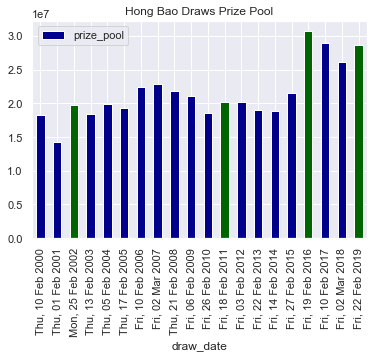

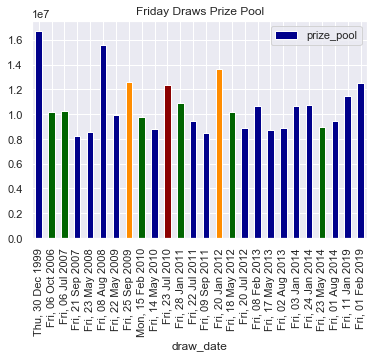

In [25]:
color_map = {
    0: 'darkblue',
    1: 'darkgreen',
    2: 'darkorange',
    3: 'darkred'
}

hong_baos_plot = hong_baos.plot.bar(x='draw_date', y='prize_pool', color=hong_baos['consecutive'].map(color_map))
hong_baos_plot.set_title('Hong Bao Draws Prize Pool')

fridays_plot = fridays.plot.bar(x='draw_date', y='prize_pool', color=fridays['consecutive'].map(color_map))
fridays_plot.set_title('Friday Draws Prize Pool')

Text(0.5, 1.0, 'Prize Pool of Usual Draws Without Snowball')

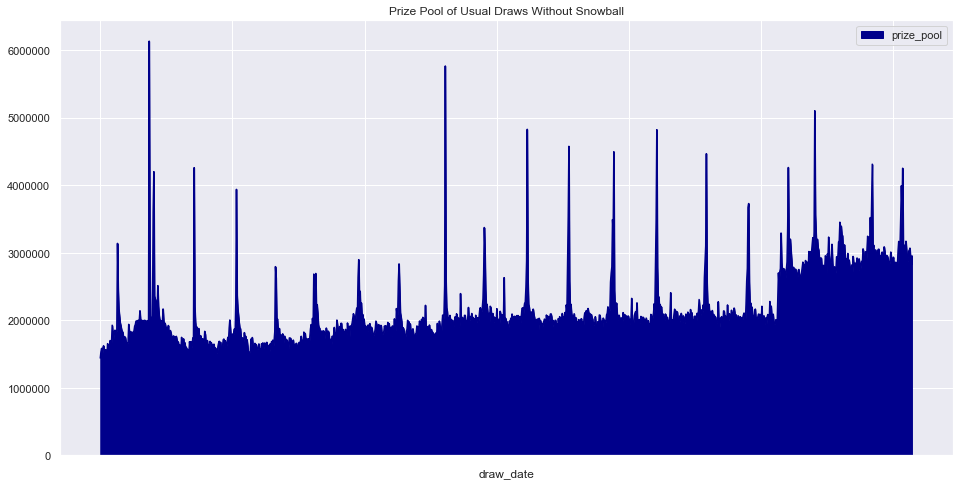

In [26]:
wo_snowball = draws[draws['usual'] & (draws['consecutive'] == 0)]
wo_snowball_plot = wo_snowball.plot.area(x='draw_date', y='prize_pool', color='darkblue', figsize=(16, 8))
wo_snowball_plot.set_title('Prize Pool of Usual Draws Without Snowball')

Text(0.5, 1.0, 'Relationship between Jackpot Snowballed Amount & Prize Pool')

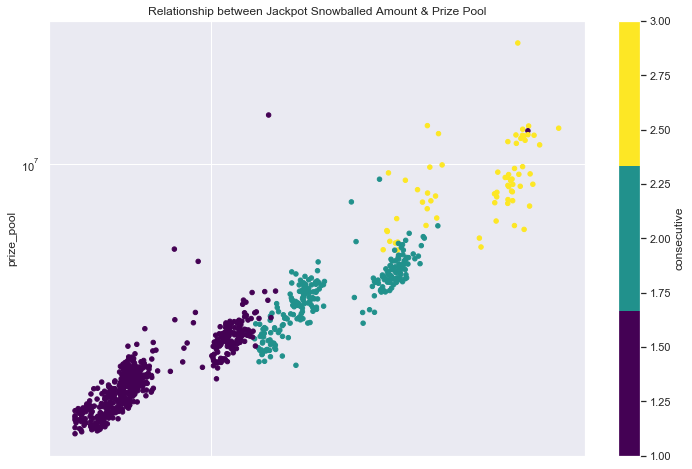

In [27]:
w_snowball = draws[draws['usual'] & (draws['consecutive'] > 0)]

from pylab import cm
w_snowball_plot = w_snowball.plot.scatter(x='snowballed_1', y='prize_pool', c='consecutive',
                                          logx=True, logy=True, colormap=cm.get_cmap('viridis', 3), figsize=(12, 8))
w_snowball_plot.set_title('Relationship between Jackpot Snowballed Amount & Prize Pool')